### RTE is classifying relationships between pairs of sentences as entailment or not. 

### Importing the required libraries

In [ ]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if gpu is availabe

In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset('glue', 'rte')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

### Using the tokenizer from huggingface

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-rte")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [6]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 2,
                                                      output_attentions = True, 
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-rte")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Forming dataloaders

In [11]:
tokenised_dataset = tokenizer(dataset['train']['sentence1'], dataset['train']['sentence2'], padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [9]:
tokenised_dataset = tokenizer(dataset['test']['sentence1'], dataset['test']['sentence2'], padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Getting CLS hidden states for all layers [13, number of sampes, 768] to check layer-wise accuracy

In [8]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [13]:
hiddenStates = getCLSHiddenStates(preTrainedModel, train_dataloader)
preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTrain, 'preTrainedCLSHiddenStatesTrain_rte.pt')
preTrainedCLSHiddenStatesTrain.shape

torch.Size([2490, 768])

In [14]:
hiddenStates = getCLSHiddenStates(fineTunedModel, train_dataloader)
fineTunedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTrain, 'fineTunedCLSHiddenStatesTrain_rte.pt')
fineTunedCLSHiddenStatesTrain.shape

torch.Size([2490, 768])

In [15]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader)
preTrainedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTest, 'preTrainedCLSHiddenStatesTest_rte.pt')
preTrainedCLSHiddenStatesTest.shape

torch.Size([3000, 768])

In [16]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader)
fineTunedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTest, 'fineTunedCLSHiddenStatesTest_rte.pt')
fineTunedCLSHiddenStatesTest.shape

torch.Size([3000, 768])

In [12]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            Pred = []
            for j in range(len(pred)):
                if pred[j]==0:
                    Pred.append('entailment')
                else:
                    Pred.append('not_entailment')
            predictions.extend(Pred)
    return predictions

In [13]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader)
filename = 'RTE.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Forming logistic regressions at each layer to find the layer-wise accuracy for pre-trained and fine-tuned model

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label']) 
    
    preTrain_pred=logreg.predict(xtest)
    pPred = []
    for j in range(len(preTrain_pred)):
        if preTrain_pred[j]==0:
            pPred.append('entailment')
        else:
            pPred.append('not_entailment')
    filename = 'p{0}/RTE.tsv'.format(i)
    result = pd.DataFrame(pPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    fineTuned_pred=logreg.predict(xtest)
    fPred = []
    for j in range(len(fineTuned_pred)):
        if fineTuned_pred[j]==0:
             fPred.append('entailment')
        else:
            fPred.append('not_entailment')
    filename = 'f{0}/RTE.tsv'.format(i)
    result = pd.DataFrame(fPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

### Finding the accuracy of the final layer using the classifier of the fine-tuned model

In [19]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=2,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

pooled_output = activation(dense(fineTunedCLSHiddenStatesTest[-1,:,:].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [20]:
import pandas as pd
predictions = predictions.to('cpu')
Pred = []
for j in range(len(predictions)):
    if predictions[j]==0:
        Pred.append('entailment')
    else:
        Pred.append('not_entailment')
predictions = np.array(Pred)
    
filename = 'passiveRTE.tsv'.format(i)
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Obtaining hidden states to find the CKA metric between the pre-trained and fine-tuned model on test dataset

In [21]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [22]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_rte.pt')
preTrainedHiddenStates.shape

torch.Size([13, 3000, 768])

In [23]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_rte.pt')
fineTunedHiddenStates.shape

torch.Size([13, 3000, 768])

In [24]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [25]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('RTE_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('RTE_preTrained_fineTuned.jpg',  bbox_inches='tight')

### STIR

In [3]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_rte.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_rte.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 3000, 768]) torch.Size([13, 3000, 768])


In [4]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [5]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [6]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [7]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [8]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [9]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [10]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [11]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [12]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.99603075 0.9735367  0.9429787  0.9453601  0.9296365  0.8901561
 0.86261815 0.8502364  0.8253259  0.7991188  0.76531756 0.7460944
 0.6946425 ]
STIRm1m2: [0.9960273  0.9728147  0.94456714 0.94202083 0.9282759  0.8889122
 0.8672045  0.8562021  0.83010006 0.802162   0.7725085  0.7618361
 0.7180695 ]
CKA: [1.         0.99990743 0.9991304  0.99857503 0.99711484 0.9949523
 0.9927621  0.9921684  0.9905099  0.98677677 0.98054403 0.97354805
 0.9601265 ]


In [1]:
STIRm2m1 =  [0.99603075 ,0.9735367 , 0.9429787  ,0.9453601,  0.9296365 , 0.8901561,
             0.86261815, 0.8502364,  0.8253259,  0.7991188 , 0.76531756 ,0.7460944,
             0.6946425 ]
STIRm1m2 = [0.9960273 , 0.9728147 , 0.94456714 ,0.94202083, 0.9282759 , 0.8889122,
            0.8672045 , 0.8562021 , 0.83010006, 0.802162 ,  0.7725085,  0.7618361,
            0.7180695 ]
CKA =  [1.,         0.99990743, 0.9991304,  0.99857503, 0.99711484 ,0.9949523,
        0.9927621 , 0.9921684 , 0.9905099,  0.98677677, 0.98054403, 0.97354805, 0.9601265 ]

In [3]:
import numpy as np
np.round(CKA, 2)

array([1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.99, 0.99, 0.99, 0.98,
       0.97, 0.96])

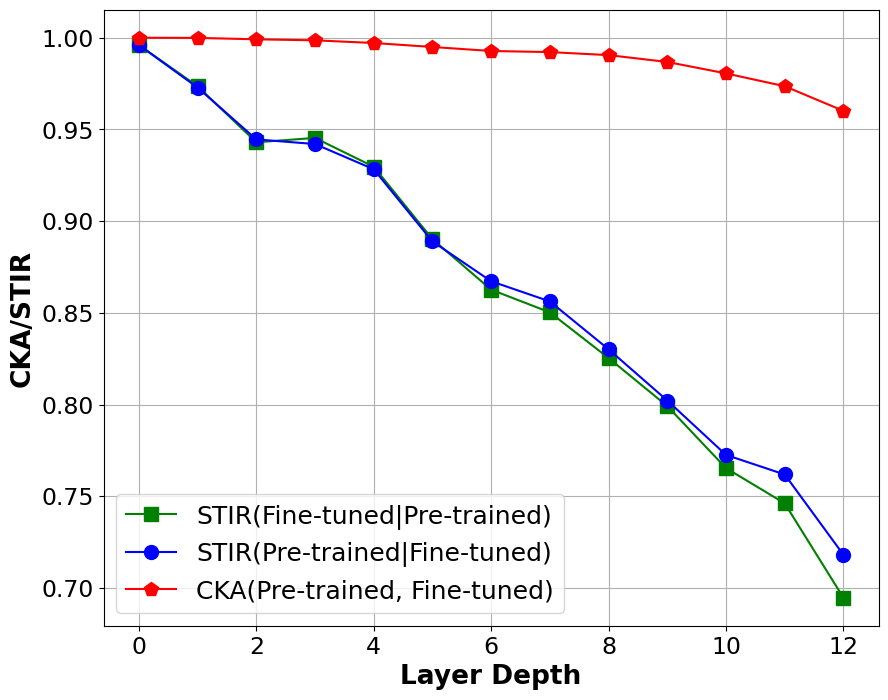

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('RTE STIR.pdf', bbox_inches='tight')
plt.savefig('RTE STIR.jpg', bbox_inches='tight')